In [1]:
!pip install transformers

In [1]:
import requests
import torch
from PIL import Image
from transformers import MllamaForConditionalGeneration, AutoProcessor
import numpy as np
import matplotlib.pyplot as plt

In [2]:
images = np.load("data_x.npy")
labels = np.load("data_y.npy", allow_pickle=True)

In [3]:
print(images.shape)

(529, 128, 128, 3)


In [4]:
print(labels.shape)

(529, 1)


In [5]:
print(np.unique(labels))

['aluminum_can' 'boxes' 'glass_bottle' 'paper_cup' 'plastic_bottle'
 'soda_can']


In [93]:
print(labels[226:232])

[['boxes']
 ['boxes']
 ['boxes']
 ['soda_can']
 ['soda_can']
 ['soda_can']]


In [6]:
img = Image.fromarray(images[0], 'RGB')

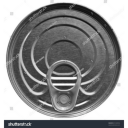

In [7]:
img

In [8]:
!huggingface-cli login --token YOUR_TOKEN --add-to-git-credential

Token is valid (permission: read).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.
Token has not been saved to git credential helper.
Your token has been saved to /home/ubuntu/.cache/huggingface/token
Login successful


In [9]:
model_id = "meta-llama/Llama-3.2-11B-Vision-Instruct"

model = MllamaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)
model.tie_weights()

The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [10]:
processor = AutoProcessor.from_pretrained(model_id)

In [ ]:
#url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/0052a70beed5bf71b92610a43a52df6d286cd5f3/diffusers/rabbit.jpg"
#image = Image.open(requests.get(url, stream=True).raw)

In [111]:
def mapResult(s):
    if s == "Aluminum Can":
        return "aluminum_can"
    elif s == "Box":
        return "boxes"
    elif s == "Glass bottle":
        return "glass_bottle"
    elif s == "Paper cup":
        return "paper_cup"
    elif s == "Plastic bottle":
        return "plastic_bottle"
    elif s == "Soda can":
        return "soda_can"
    

In [104]:
text = """
"Tell me which of the following items is most likely to be the image. Select only 1 item from the following list: 

1.) Aluminum Can
2.) Box
3.) Glass bottle
4.) Paper cup
5.) Plastic bottle
6.) Soda can

Output only the item name."""
print(text)


"Tell me which of the following items is most likely to be the image. Select only 1 item from the following list: 

1.) Aluminum Can
2.) Box
3.) Glass bottle
4.) Paper cup
5.) Plastic bottle
6.) Soda can

Output only the item name.


In [105]:
messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": text}
    ]}
]

In [106]:
input_text = processor.apply_chat_template(messages, add_generation_prompt=False)

In [121]:
from string import punctuation

results = []
pred_labels = []

for i in range(len(images)):
    step = i % 10
    if step == 0:
        print("processed", i)
    img = Image.fromarray(images[i], 'RGB')
    inputs = processor(
        img,
        input_text,
        add_special_tokens=False,
        return_tensors="pt"
    ).to(model.device)

    output = model.generate(**inputs, max_new_tokens=30)
    result = processor.decode(output[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)
    lines = result.splitlines()
    item = lines[14].strip(punctuation)
    results.append(item)
    pred_labels.append(mapResult(item))
    

processed 0
processed 10
processed 20
processed 30
processed 40
processed 50
processed 60
processed 70
processed 80
processed 90
processed 100
processed 110
processed 120
processed 130
processed 140
processed 150
processed 160
processed 170
processed 180
processed 190
processed 200
processed 210
processed 220
processed 230
processed 240
processed 250
processed 260
processed 270
processed 280
processed 290
processed 300
processed 310
processed 320
processed 330
processed 340
processed 350
processed 360
processed 370
processed 380
processed 390
processed 400
processed 410
processed 420
processed 430
processed 440
processed 450
processed 460
processed 470
processed 480
processed 490
processed 500
processed 510
processed 520


In [122]:
print(len(results))

529


In [123]:
print(len(pred_labels))

529


In [124]:
# open file
with open('results_raw.txt', 'w+') as f:
    
    # write elements of list
    for item in results:
        f.write('%s\n' %item)
    
    print("File written successfully")


# close the file
f.close()

File written successfully


In [125]:
# open file
with open('pred_labels.txt', 'w+') as fl:
    
    # write elements of list
    for item in pred_labels:
        fl.write('%s\n' %item)
    
    print("File written successfully")


# close the file
fl.close()

File written successfully


In [17]:
numCorrect = 0
for i in range(len(labels)):
    if (labels[i][0] == pred_labels[i]):
        numCorrect = numCorrect + 1

acc = (numCorrect / len(labels)) * 100
print(acc)

80.71833648393195


In [ ]:
from numpy import loadtxt

In [16]:
pred_labels = loadtxt('pred_labels.txt', dtype=str)
print(pred_labels.shape)
print(pred_labels[:10])

(529,)
['aluminum_can' 'aluminum_can' 'aluminum_can' 'aluminum_can'
 'aluminum_can' 'aluminum_can' 'aluminum_can' 'aluminum_can'
 'aluminum_can' 'aluminum_can']


In [18]:
import numpy as np

labels = np.load("data_y.npy", allow_pickle=True)
labels = labels.flatten()
print(labels.shape)
print(labels[:10])

(529,)
['aluminum_can' 'aluminum_can' 'aluminum_can' 'aluminum_can'
 'aluminum_can' 'aluminum_can' 'aluminum_can' 'aluminum_can'
 'aluminum_can' 'aluminum_can']


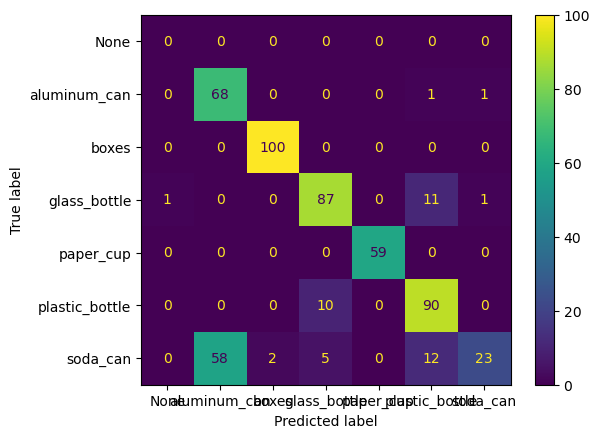

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(labels, pred_labels)
plt.show()